Primary Analysis and Feature Importance Assessment.

In [8]:
import numpy as np
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import shap

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import time
import math
import warnings

warnings.filterwarnings(action='ignore')

In [9]:
# load data
dataset = pl.read_parquet("../data/clean/dataset.parquet")
sbmssn = pl.read_parquet("../data/clean/sbmssn.parquet")

dataset.shape

(8585, 290)

In [10]:
# apply categorical encoding
dataset_x = dataset.drop(['target']).to_pandas()
dataset_y = dataset.get_column('target').to_pandas()
newdata = sbmssn.drop('child_id').to_pandas()

In [11]:
# dataset for lightgbm
lgb_train = lgb.Dataset(data=dataset_x, label=dataset_y)

In [12]:
# declare base parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 32,
    'min_gain_to_split': 0,
    'feature_fraction_bynode': 1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'cat_l2': 10,
    'cat_smooth': 10,
    'verbosity': -1,
    'seed': 0
}

In [13]:
# update with tuned params
params.update({'feature_fraction': 0.7274049492997424, 'cat_l2': 7.338696749456784, 'cat_smooth': 9.793892656173774})

In [14]:
# fit the model with the tuned param and k-fold cv for the boosting iterations
cv = lgb.cv(
    params=params,
    num_boost_round=5000,
    train_set=lgb_train,
    nfold=10,
    seed=0,
    eval_train_metric=True,
    stratified=False
)

In [15]:
optimal_rounds = np.argmin(cv['valid rmse-mean'])
best_cv_score = min(cv['valid rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds, best_cv_score, cv['valid rmse-stdv'][optimal_rounds]))


Optimal Round: 2269
Optimal Score: 9.330065278870446 + 0.22365261254896204


In [16]:
# fit final model on complete training data
params.update({'num_iterations': optimal_rounds})

bst = lgb.train(
    params=params,
    train_set=lgb_train,
)

In [17]:
# create final predictions
newdata_pred = bst.predict(newdata)

In [18]:
# explain final model
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dataset_x)

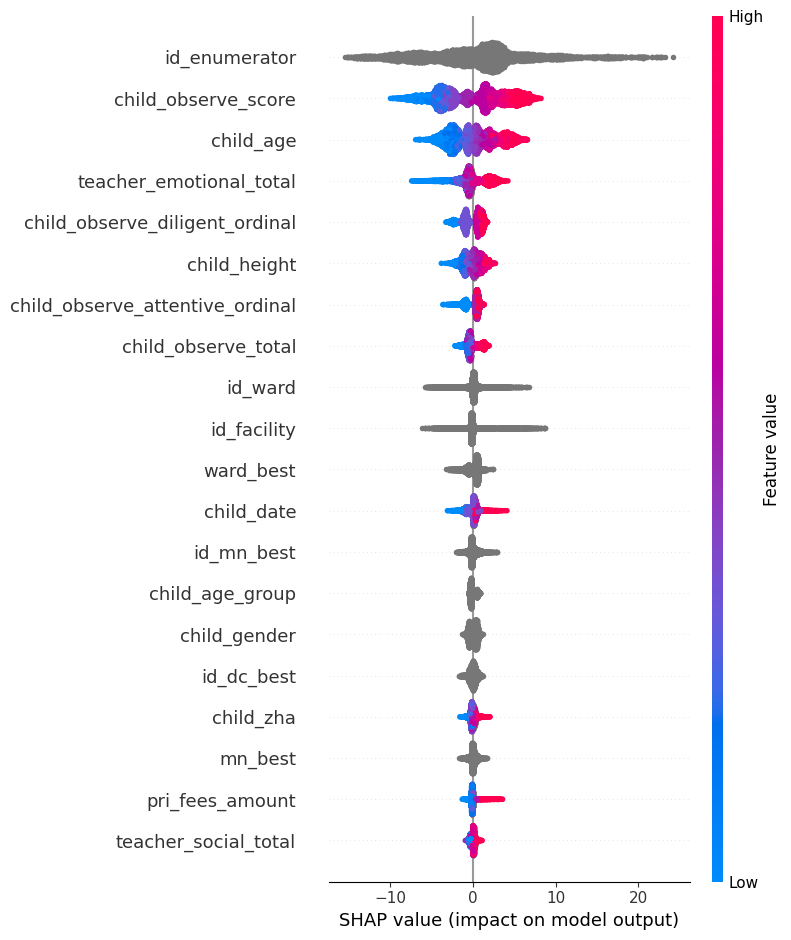

In [19]:
shap.summary_plot(shap_values, dataset_x)

In [20]:
# create ranking of shap value
ft = {
    'feature_1': [], 'feature_2': [], 'feature_3': [], 'feature_4': [], 'feature_5': [], 'feature_6': [], 'feature_7': [],
    'feature_8': [], 'feature_9': [], 'feature_10': [], 'feature_11': [], 'feature_12': [], 'feature_13': [], 'feature_14': [],
    'feature_15': []
}

shap_values = explainer.shap_values(newdata)

for sv in shap_values: 
    arr = np.argsort(sv)[::-1][:15]
    for ind, a in enumerate(arr):
        place = f'feature_{ind+1}'
        ft[place].append(newdata.columns[a])

final_sub = sbmssn.select('child_id')
final_sub = final_sub.with_columns(pl.Series(newdata_pred).alias('target'))

ft = pl.DataFrame(ft)
final_sub = pl.concat([final_sub, ft], how='horizontal')

fname = '../submission/' + time.strftime("%Y%m%d-%H%M%S") + '.csv'
final_sub.write_csv(fname)